Evaluating hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64, 'dropout_prob': 0.3}


100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/15, Validation F1: 0.6148
Epoch 2/15, Validation F1: 0.6778
Epoch 3/15, Validation F1: 0.7366
Epoch 4/15, Validation F1: 0.7764
Epoch 5/15, Validation F1: 0.7886
Epoch 6/15, Validation F1: 0.8077
Epoch 7/15, Validation F1: 0.8174
Epoch 8/15, Validation F1: 0.8220
Epoch 9/15, Validation F1: 0.8301
Epoch 10/15, Validation F1: 0.8342
Epoch 11/15, Validation F1: 0.8384
Epoch 12/15, Validation F1: 0.8470
Epoch 13/15, Validation F1: 0.8472
Epoch 14/15, Validation F1: 0.8479
Epoch 15/15, Validation F1: 0.8546
Evaluating hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64, 'dropout_prob': 0.5}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Validation F1: 0.5743
Epoch 2/15, Validation F1: 0.6835
Epoch 3/15, Validation F1: 0.7487
Epoch 4/15, Validation F1: 0.7704
Epoch 5/15, Validation F1: 0.7811
Epoch 6/15, Validation F1: 0.8071
Epoch

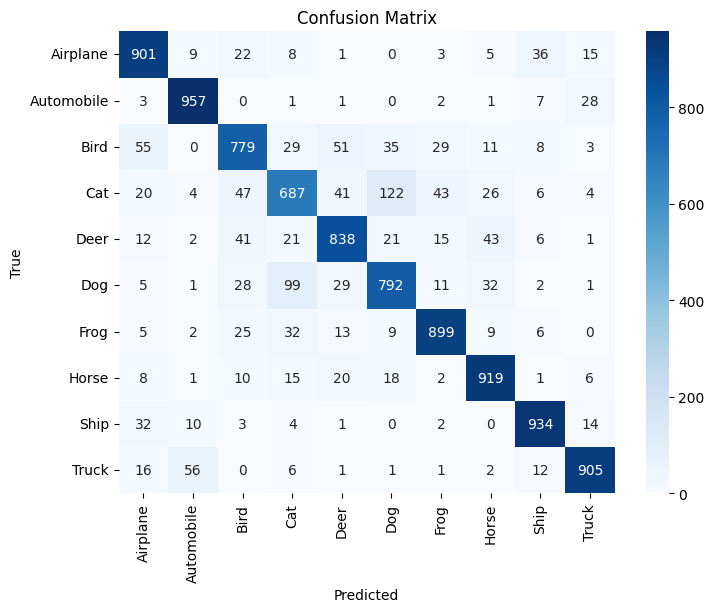

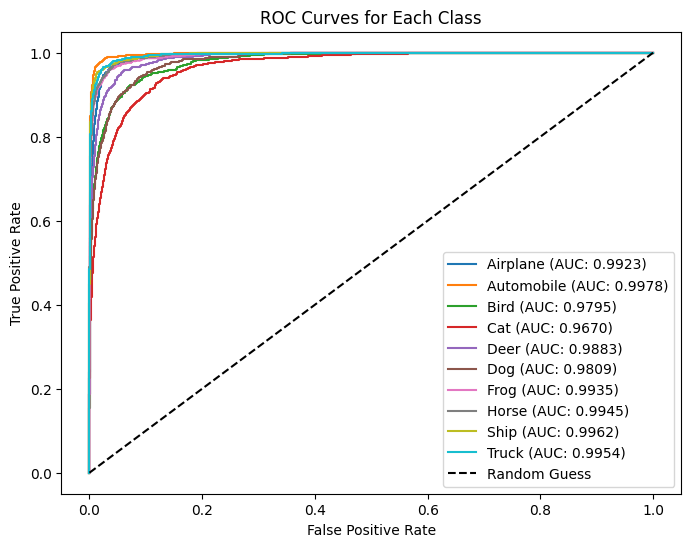

2024/12/09 18:58:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/09 18:59:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/09 18:59:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns
from itertools import product

# CIFAR-10 Label Names
CIFAR10_LABELS = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Define the Improved CNN Model with dropout as a hyperparameter
class ImprovedCNNModel(nn.Module):
    def __init__(self,dropout_prob):
        super(ImprovedCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.5),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),  # Reduced size of fully connected layer
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 10)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Data loading and preprocessing
def load_data_with_validation(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# Train the model and calculate F1 for training data
def train_model_with_f1(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average="weighted")
    return total_loss / len(train_loader), 100 * correct / total, f1

# Evaluate model with metrics
def evaluate_model_with_metrics(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            probs = outputs.softmax(dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    return total_loss / len(data_loader), 100 * correct / total, f1, cm, all_labels, all_predictions, all_probs

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_val_f1 = 0
    best_hyperparams = None

    for params in hyperparameter_space:
        print(f"Evaluating hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_validation(params["batch_size"])
        model = ImprovedCNNModel(params["dropout_prob"]).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        for epoch in range(params["num_epochs"]):
            train_model_with_f1(model, train_loader, criterion, optimizer, device)
            _, _, val_f1, _, _, _, _ = evaluate_model_with_metrics(model, val_loader, criterion, device)

            print(f"Epoch {epoch + 1}/{params['num_epochs']}, Validation F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_hyperparams = params

    print(f"Best hyperparameters: {best_hyperparams}, Best Validation F1: {best_val_f1:.4f}")
    return best_hyperparams

# Train and evaluate final model
def train_and_test_final_model_with_visualizations(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_validation(best_hyperparams["batch_size"])
    model = ImprovedCNNModel(best_hyperparams["dropout_prob"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams["learning_rate"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams["num_epochs"]):
            train_loss, train_acc, train_f1 = train_model_with_f1(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, val_f1, _, _, _, _ = evaluate_model_with_metrics(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, cm, all_labels, all_predictions, all_probs = evaluate_model_with_metrics(
                model, test_loader, criterion, device
            )

            # Log metrics
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)
            mlflow.log_metric("train_f1", train_f1, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)
            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_accuracy", test_acc, step=epoch)
            mlflow.log_metric("test_f1", test_f1, step=epoch)

            print(
                f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}"
            )

            scheduler.step()

        # Log confusion matrix and ROC curves
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=CIFAR10_LABELS, yticklabels=CIFAR10_LABELS, cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.show()

        plt.figure(figsize=(8, 6))
        for i in range(10):
            y_true_class = (np.array(all_labels) == i).astype(int)
            fpr, tpr, _ = roc_curve(y_true_class, np.array(all_probs)[:, i])
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{CIFAR10_LABELS[i]} (AUC: {auc_score:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves for Each Class")
        plt.legend(loc="lower right")
        plt.savefig("roc_curves_per_class.png")
        mlflow.log_artifact("roc_curves_per_class.png")
        plt.show()

        mlflow.pytorch.log_model(model, "model")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    dropout_probs = [0.3, 0.5]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs, "dropout_prob": dp}
        for lr, ne, bs, dp in product(learning_rates, num_epochs_list, batch_sizes, dropout_probs)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model
    train_and_test_final_model_with_visualizations(best_hyperparams, device)
